In [8]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget
import warnings

import emd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Import Reflection and PL

paths = glob("../data/2023-10-*/d*.asc")
paths += glob("../data/2023-11-*/d*.asc")

def load_spectrum(p):
	data = np.loadtxt(p)
	wavelength = data[:,0]
	counts = data[:,1]
	metadata = extract_metadata(p)
	if "capture" in metadata and metadata["capture"] is not None:
		number = int(metadata["capture"].split("x")[0])
		exposure = float(metadata["capture"].split("x")[1].split("s")[0])
		metadata = {**metadata, "number": number, "exposure": exposure}
		counts = counts / exposure / number
	
	ar = xr.DataArray(
		data=counts,
		coords={"wavelength": wavelength},
		attrs=metadata,
		name=metadata["name"],
	)
	ar.name = metadata["name"]
	ar = ar.assign_coords(energy=1239.84193/ar.wavelength)
	return ar

def custom_load(p):
	try: return load_spectrum(p)
	except ValueError:
		# print(f"Could not load {p}")
		return None

data = [custom_load(p) for p in paths]
n_failed = len([d for d in data if d is None])
print(fr"Failed to load {n_failed} of {len(data)}")
data = [d for d in data if d is not None]

for d in data: d = d.assign_coords(energy=1239.84193/d.wavelength)

Failed to load 6 of 86


# Show Signal Plot

## big crystals

In [10]:
pprint([d.method for d in data if "10-30" in d.name])

['reflectance', None, 'reflectance', 'reflectance']


In [11]:
# data before the 2023-11-07
sel = [d for d in data  if "ref" in d.name.lower() and d.attrs["date"] < pd.to_datetime("2023-11-07")]
print("datasets: \t", len(sel))

sel = [d for d in sel if "off" not in d.name]
crystals = sel

pprint([d.name for d in sel])   

datasets: 	 10
['2023-10-30/d003_NiPS3_REF_2x1s_20K.asc',
 '2023-10-30/d004_FePS3_REF_2x1s_20K.asc',
 '2023-10-30/d001_MnPS3_REF_2x1s_20K.asc',
 '2023-10-31/d001_NiPS3_20K_refl_2x5s.asc',
 '2023-10-31/d001_NiPS3_10K_refl_2x5s_differentspot.asc',
 '2023-10-31/d016_CrPS4_10K_refl_5x1s.asc',
 '2023-10-31/d015_FePS3_10K_refl_2x5s.asc',
 '2023-10-31/d001_NiPS3_10K_refl_2x5s.asc',
 '2023-11-06/d003_refl_onFlake_NiPS3.asc']


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


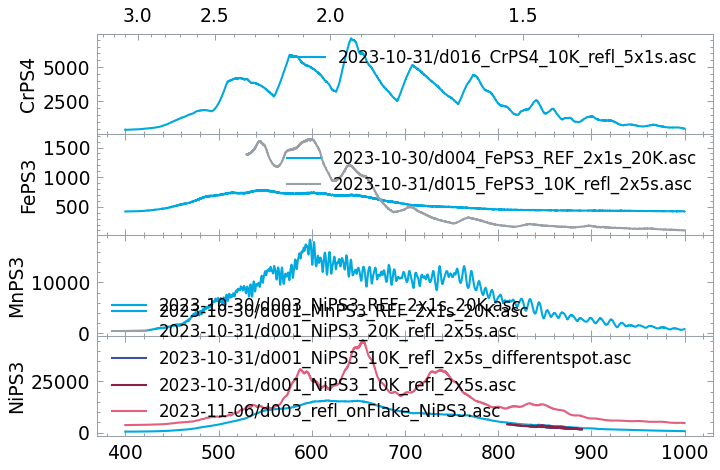

In [12]:
group_material = groupby_list(crystals, lambda f: f.material)

fig, axs = plt.subplots(len(group_material), 1, sharex=True)

for ax, (material, fl) in zip(axs.flatten(), group_material.items()):
    for f in fl:
        f.plot(ax=ax, label=f.name, _labels=False)
    ax.set_ylabel(material)
    ax.legend(fontsize=FONTSIZE_TINY)
   
plot.energy_ticks(axs[0])
plt.tight_layout() 
plt.subplots_adjust(hspace=0)
plt.show()

In [13]:
group_material

{'CrPS4': [<xarray.DataArray '2023-10-31/d016_CrPS4_10K_refl_5x1s.asc' (wavelength: 5940)> Size: 48kB
  array([426.4  , 425.12 , 425.232, ..., 519.078, 519.476, 517.04 ])
  Coordinates:
    * wavelength  (wavelength) float64 48kB 400.0 400.1 400.2 ... 999.9 1e+03
      energy      (wavelength) float64 48kB 3.1 3.099 3.098 ... 1.24 1.24 1.24
  Attributes:
      experiment:   16
      material:     CrPS4
      method:       reflectance
      capture:      5x1s
      temperature:  10.0
      angle:        None
      name:         2023-10-31/d016_CrPS4_10K_refl_5x1s.asc
      date:         2023-10-31 00:00:00
      remaining:    None
      path:         ../data/2023-10-31/d016_CrPS4_10K_refl_5x1s.asc
      number:       5
      exposure:     1.0],
 'FePS3': [<xarray.DataArray '2023-10-30/d004_FePS3_REF_2x1s_20K.asc' (wavelength: 6759)> Size: 54kB
  array([420.5   , 421.8405, 421.938 , ..., 423.5555, 424.5   , 422.747 ])
  Coordinates:
    * wavelength  (wavelength) float64 54kB 400.0 400.1

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


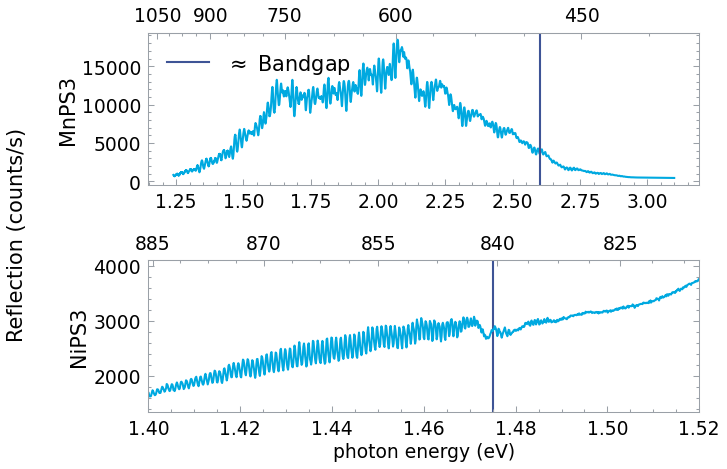

In [14]:
group_material = groupby_list(crystals, lambda f: f.material)

group_material = {
    "MnPS3": group_material["MnPS3"],
    "NiPS3": group_material["NiPS3"],
}

fig, axs = plt.subplots(len(group_material), 1)

group_material["NiPS3"] = [
    [d for d in data if "Ni" in d.name and d.method == "reflectance" and "off" not in d.name and "dark" not in d.name][2]
]

for ax, (material, fl) in zip(axs.flatten(), group_material.items()):
    [f for f in fl if len(f) > 1000][0].plot(ax=ax, _labels=False, x="energy")
    ax.set_ylabel(material, fontsize=FONTSIZE)
    # ax.legend(fontsize=FONTSIZE_TINY)

axs[0].axvline(2.6, color="C2", lw=1, label=r"$\approx$ Bandgap")
axs[0].legend(loc="upper left")

# add a box in axs[1]
# d = [f for f in group_material["NiPS3"] if len(f) > 1000][0]
# energy = (1.40, 1.52)
# min_c = d.where(d.energy > energy[0]).where(d.energy < energy[1]).min().values
# max_c = d.where(d.energy > energy[0]).where(d.energy < energy[1]).max().values
# axs[1].add_patch(
#     mpl.patches.Rectangle(
#         (energy[0], min_c), energy[1] - energy[0], max_c - min_c,
# 		linewidth=1, edgecolor=SEEGRAU, 
#         facecolor='none', zorder=10
#     )
# )
# axins = axs[1].inset_axes([0.4, 0.15, 0.55, 0.8])
# [f for f in group_material["NiPS3"] if len(f) > 1000][0].plot(ax=axins, label=f.name, _labels=False, x="energy", lw=.5)
# axins.set_xlim(energy)
# axins.set_ylim(min_c, max_c)
# axins.set_yticks([])
axs[-1].set_xlim(1.4, 1.52)
axs[-1].axvline(1.475, color="C2", lw=1, zorder=0)

for a in axs: plot.energy_ticks(a)
plt.xlabel("photon energy (eV)")
fig.supylabel("Reflection (counts/s)", fontsize=FONTSIZE)
plt.tight_layout() 
# plt.subplots_adjust(hspace=0)
plt.savefig("../report/figures/2024-03-14 reflection spectra.pdf")
plt.show()

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


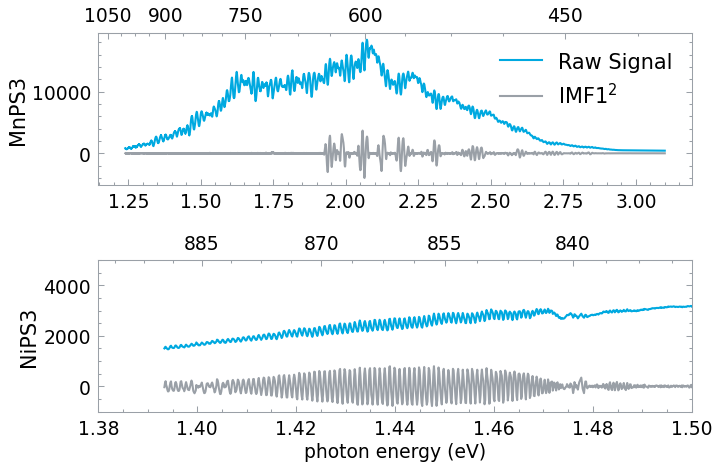

In [15]:
group_material = groupby_list(crystals, lambda f: f.material)

group_material = {
    "MnPS3": group_material["MnPS3"],
    "NiPS3": group_material["NiPS3"],
}

group_material["NiPS3"] = [
    [d for d in data if "Ni" in d.name and d.method == "reflectance" and "off" not in d.name and "dark" not in d.name][2]
]

fig, axs = plt.subplots(len(group_material), 1)

for ax, (material, fl) in zip(axs.flatten(), group_material.items()):
    f = [f for f in fl if len(f) > 1000][0]
    f.plot(ax=ax, label=f.name, _labels=False, x="energy")
    e =  emd.sift.sift(f.values)[:,0]
    # e = np.sign(e) * e**2
    e = e / e.max() * f.values.max() * .2
    ax.plot( f.energy, e)
    ax.set_ylabel(material, fontsize=FONTSIZE)
    # ax.legend(fontsize=FONTSIZE_TINY)

axs[1].set_xlim(1.38, 1.5)
axs[1].set_ylim(None, 5000)
   
axs[0].legend(["Raw Signal", "IMF1$^2$"])
for a in axs: plot.energy_ticks(a)
plt.xlabel("photon energy (eV)")
plt.tight_layout()
# plt.subplots_adjust(hspace=0)
plt.savefig("../report/figures/2024-03-14 reflection spectra IMF.pdf")
plt.show()

In [16]:
from scipy.signal import lombscargle
from scipy.constants import pi
import emd

def thickness(wavelength, intensity, thickness, filtered=True):
    """
    Calculate the signal for different thicknesses.

    thickness (np.array): $d n cos \theta2$
    
    Source: 
    A method for measuring and calibrating the thickness of thin films based on infrared interference technology
    """
    if filtered: imf = emd.sift.sift(intensity)[:,0]
    else: imf = intensity
    nu = 1/wavelength
    w = 2*thickness * 2*pi
    pgram = lombscargle(nu, imf, w)
    return pgram

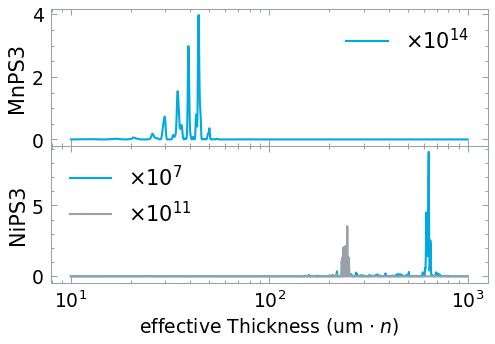

In [17]:
thicknesses = np.geomspace(10, 1e3, 1000) *1e3

flakes_material = groupby_list(crystals, lambda f: f.material)

flakes_material = {
    "MnPS3": flakes_material["MnPS3"],
    "NiPS3": flakes_material["NiPS3"],
    # "CrPS4": flakes_material["CrPS4"],
    # "FePS3": flakes_material["FePS3"]
}

fig, axs = plt.subplots(len(flakes_material), 1, sharex=True, 
    figsize=FIGSIZE_MEDIUM,
    # sharey=True 
)

for ax, (material, fl) in zip(axs.flatten(), flakes_material.items()):    
    for f in fl:
        if len(f)>2000:
            sig = thickness(f.wavelength, f.data, thicknesses, filtered=True)**2
            fac = int(np.floor(np.log10(sig.max())))
            sig = sig/10**fac
            lin = ax.plot(thicknesses*1e-3, sig, label=f"$\\times 10^{{{fac}}}$")
    ax.set_ylabel(material, fontsize=FONTSIZE)
    ax.legend()
    ax.set_xscale("log")
    # ax.set_yticks([])
    # ax.legend(fontsize=FONTSIZE_TINY)
   
plt.tight_layout() 
plt.subplots_adjust(hspace=0)
plt.xlabel(r"effective Thickness (um $\cdot \; n$)")
plt.savefig("../figures/2024-03-14 thickness.pdf")
plt.show()

## flakes
ab dem 2023-11-07 wurden exf. flakes angesehen mit dicken von 100-1000nm

In [19]:
# normalized reflection spectra of flakes

sel = [d for d in data if "refl" in d.name and ("on" in d.name or "off" in d.name) and d.attrs["date"] >= pd.to_datetime("2023-11-07")]
print("datasets: \t", len(sel))

sets = groupby_list(sel, lambda d: (d.date, d.experiment)).values()
print("sets: \t\t", len(sets))

sets = [s for s in sets if len([d for d in s if "on" in d.name]) > 0 and len([d for d in s if "off" in d.name]) > 0]
print("sets w.on,off: \t", len(sets))

off_sets = [[d for d in s if "off" in d.name][0] for s in sets]
on_sets = [[d for d in s if "on" in d.name] for s in sets]

flakes = []
for on_list, off in zip(on_sets, off_sets):
    min_count = min([on.count().values for on in on_list])
    min_count = min(min_count, off.count().values)
    for on in on_list:
        ar = (on-min_count)/(off.interp(wavelength=off.wavelength) - min_count)
        # ar = (on-on.min())/(off.interp(wavelength=off.wavelength) - off.min())
        ar.attrs = on.attrs
        ar.name = on.name
        flakes.append(ar)

print("normalized: \t", len(flakes))
# pprint([f.name for f in flakes])

datasets: 	 17
sets: 		 7
sets w.on,off: 	 6
normalized: 	 8


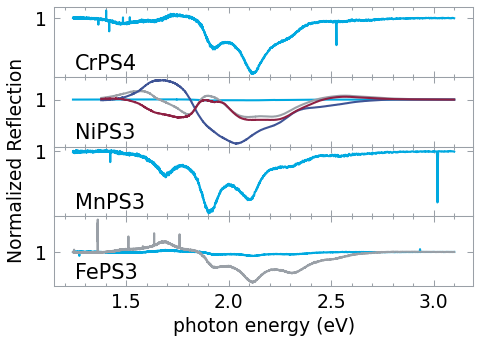

In [100]:
flakes_material = groupby_list(flakes, lambda f: f.material)

flakes_material = {
    "CrPS4": flakes_material["CrPS4"],
    "NiPS3": flakes_material["NiPS3"],
    "MnPS3": flakes_material["MnPS3"],
    "FePS3": flakes_material["FePS3"]
}

fig, axs = plt.subplots(len(flakes_material), 1, sharex=True, figsize=FIGSIZE_MEDIUM)

for ax, (material, fl) in zip(axs.flatten(), flakes_material.items()):    
    for f in fl:
        f.plot(ax=ax, label=f.name, _labels=False, x="energy")
    # ax.set_ylabel(material)
    ax.text(0.05, 0.05, material, transform=ax.transAxes, fontsize=FONTSIZE, verticalalignment='bottom')
    # ax.legend(fontsize=FONTSIZE_TINY)
    ax.set_yticks([1])

# plot.energy_ticks(axs[0])
plot.hide_inner_label()
fig.supylabel("Normalized Reflection", fontsize=FONTSIZE_SMALL, x=0.07)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
axs[-1].set_xlabel("photon energy (eV)")
plt.savefig("../report/figures/2024-04-10 normalized reflection spectra.pdf")
plt.show()

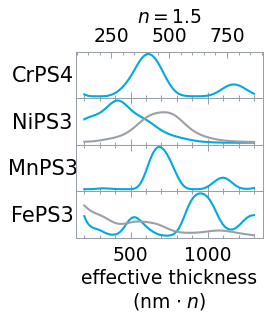

In [105]:
# thicknesses = np.geomspace(100, 1200, 100)
thicknesses = np.geomspace(200, 1300, 100)

flakes_material = groupby_list(flakes, lambda f: f.material)

flakes_material = {
    "CrPS4": flakes_material["CrPS4"],
    "NiPS3": np.array(flakes_material["NiPS3"], dtype=xr.DataArray)[[1, 2]],
    "MnPS3": flakes_material["MnPS3"],
    "FePS3": flakes_material["FePS3"]
}

fig, axs = plt.subplots(len(flakes_material), 1, sharex=True, figsize=(2, FIGSIZE_MEDIUM[1]))

for ax, (material, fl) in zip(axs.flatten(), flakes_material.items()):    
    for f in fl:
        sig = thickness(f.wavelength, f.data, thicknesses, filtered=True)**2
        fac = int(np.floor(np.log10(sig.max())))
        sig = sig/10**fac
        lin = ax.plot(thicknesses, sig, label=f"$\\times 10^{{{fac}}}$")
    ax.set_ylabel(material, fontsize=FONTSIZE, rotation=0, labelpad=16, verticalalignment="center")
    # ax.set_xscale("log")
    # ax.legend()
    # ax.legend(fontsize=FONTSIZE_TINY)
    ax.set_yticks([])
    # ax.text(0.05, 0.95, material, transform=ax.transAxes, fontsize=FONTSIZE, verticalalignment='top')

n = 1.5

# for a in axs:
    # a.axvspan(200*n, 700*n, color=SEEGRAU, alpha=.1, lw=0)

from matplotlib.ticker import ScalarFormatter
axs[-1].xaxis.set_major_formatter(ScalarFormatter())
# axs[-1].xaxis.set_major_locator(plt.MultipleLocator(200))
# axs[-1].set_xticks([200, 400, 600, 1000])

axs[0].xaxis.set_ticks_position('bottom')
sec_ax = axs[0].secondary_xaxis("top", functions=(lambda x: x/1.5, lambda x: x*1.5))
sec_ax.set_xlabel(r"$n=1.5$")
# sec_ax.xaxis.set_major_formatter(ScalarFormatter())
# sec_ax.set_xticks([200, 600, 1000])

plt.xlabel("effective thickness\n"+ r"(nm $\cdot \; n$)")
plot.hide_inner_label()
plt.tight_layout() 
plt.subplots_adjust(hspace=0)
# plt.savefig("../report/figures/2024-03-14 thickness flakes.pdf")
plt.show()